# Author: Katelyn M Campbell
# Assignment: Capstone Milestone 3- Feature Engineering
# Class: DSC-580
# Date: 4/23/2025

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import scipy.stats as stats
import statistics
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import sklearn
import warnings
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
import os
import math
import graphviz
from tensorflow.keras.models import Sequential
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input as KerasInput
from sklearn.pipeline import Pipeline
from sklearn.tree import plot_tree
from graphviz import Digraph
import matplotlib.image as mpimg
from dash import Dash, dcc, html, Input, Output
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import time
from urllib.request import urlopen
from scipy.stats import chi2_contingency
from sklearn.model_selection import KFold
#loads necessary packages

# Help

### Purpose:
To build a Poisson Regression, Random Forest, and DNN models with trend and seasonal feature engineering and generate reports.

### How to Run:
- Run each cell in order (previous generated information may not be captured otherwise).
- Modify the data, model and their features as needed.

### What You'll Get:
- Printed and saved reports of MSE, R-squared, and cross validation results (as .txt files).
- Printed and saved observed vs. predicted value graphs (as PNG images).

### Functions Included:
- pd.read_csv()
- train_test_split()
- sin()
- cos()
- glm()
- RandomForestRegressor()
- Sequential(), as well as add() and compile()
- fit()
- predict()
- scatter(), as well as other releavant graphing functions
- mean_squared_error()
- r2_score()
- cross_validate()
- KFold()
- print()

Please use the `help(function_name)` in a new cell to learn more about any functions.

Additional note: The interpretation is based on the model last generated by the developer. Any newly completed iterations will change the training and testing split of the data, which may impact the results. Any modifications also would alter the results. New interpretations would be required.

## Loading Data

In [50]:
def log_step(step_name):
 print(f"[{time.strftime('%Y-%m-%d %H:%M:%S')}] {step_name}")
#logs when each step was ran

In [ ]:
# option to upload url data
from dash import Dash, html, dcc, Output, Input
import pandas as pd
import dash
import json

app = Dash(__name__)
server = app.server

app.layout = html.Div([
    html.H1("Load Data from URL"),
    dcc.Input(
        id='url-input',
        type='text',
        placeholder='Enter the URL to load (.csv or .json)',
        style={'width': '60%'}
    ),
    html.Button('Load', id='load-button'),
    html.Div(id='data-output')
])

@app.callback(
    Output('data-output', 'children'),
    Input('load-button', 'n_clicks'),
    dash.dependencies.State('url-input', 'value')
)
def load_data(n_clicks, url):
    if not url:
        return "Please enter a URL."

    try:
        if url.endswith('.csv'):
            df = pd.read_csv(url)
            return html.Div([
                html.P("CSV loaded successfully."),
                html.Pre(df.head().to_string())
            ])
        elif url.endswith('.json'):
            df = pd.read_json(url)
            return html.Div([
                html.P("JSON loaded successfully."),
                html.Pre(df.head().to_string())
            ])
        else:
            return "Unsupported file type. Please enter a .csv or .json URL."
    except Exception as e:
        return f"An error occurred: {str(e)}"

if __name__ == "__main__":
    app.run_server(debug=True)

# for reading URL data

Unsupported file format or no url entered.


In [52]:
log_step("Loading Data")
data_vaccine = pd.read_csv("C:/Users/User/Downloads/daily-covid-19-vaccine-doses-administered.csv")
data_deaths = pd.read_csv("C:/Users/User/Downloads/daily-new-confirmed-covid-19-deaths-per-million-people.csv")
data = pd.merge(data_vaccine, data_deaths, on=['Entity', 'Day'], how='inner')
print("Data Loaded")
#loads data and logs time
#can replace path for different data

[2025-04-23 01:58:43] Loading Data
Data Loaded


## Data Cleaning and Preprocessing

In [53]:
log_step("Data Cleaning and Preprocessing")
# logs step

[2025-04-23 01:58:43] Data Cleaning and Preprocessing


In [54]:
data['Day'] = pd.to_datetime(data['Day'])
data['COVID_doses_daily'] = np.log1p(data['COVID-19 doses (daily)'])
data['COVID_deaths_daily'] = data["Daily new confirmed deaths due to COVID-19 per million people"] *1000000
data['COVID_deaths_daily'] =np.log1p(data['COVID_deaths_daily'])
data = data.sort_values(by=['Entity', 'Day'])
data['time_index'] = data.groupby('Entity').cumcount()
# applies log transformation, sorts data by entity and gives a time index for each (ckeans data)

In [55]:
if data.isnull().values.sum() != 0:
    data.isnull().dropna()
    print("N/A values removed from data set.")
else:
    print("No N/A values found in data set.")
# function will remove any NA values found in data set

if data.duplicated().values.sum() != 0:
    data.duplicated().drop_duplicates()
    print("Duplicated values removed from data set.")
else:
    print("No duplicated values found in data set.")
# function will remove any duplicated values found in data set

No N/A values found in data set.
No duplicated values found in data set.


In [56]:
print(data.dtypes)
#ensures all data has the correct type associated to it

Entity                                                                   object
Day                                                              datetime64[ns]
COVID-19 doses (daily)                                                  float64
Daily new confirmed deaths due to COVID-19 per million people           float64
COVID_doses_daily                                                       float64
COVID_deaths_daily                                                      float64
time_index                                                                int64
dtype: object


In [57]:
data['day_of_year'] = data['Day'].dt.dayofyear
data['sin_year'] = np.sin(2 * np.pi * data['day_of_year'] / 365)
data['cos_year'] = np.cos(2 * np.pi * data['day_of_year'] / 365)
# adds seasonality columns

In [58]:
log_step("Data Cleaned and Preprocessed")
#prints that step was completed

[2025-04-23 01:58:44] Data Cleaned and Preprocessed


## Analyzing Data

In [59]:
log_step("Analyzing Data")
#logs time step completed

[2025-04-23 01:58:44] Analyzing Data


### Poisson Regression

In [60]:
split_date = data['Day'].quantile(0.8) 
train_data = data[data['Day'] <= split_date]
test_data = data[data['Day'] > split_date]
#splits data into training and testing for Poisson

In [61]:
poisson = smf.glm(
    formula='COVID_deaths_daily ~ COVID_doses_daily + time_index + sin_year + cos_year',
    data=train_data,
    family=sm.families.Poisson()
).fit()

# generates Poisson model

In [62]:
predictions_poisson = poisson.predict(test_data)
# creates predictions from poisson model (Brownlee, 2022)

### Random Forest

In [63]:
X = data[['COVID_doses_daily', 'time_index', 'day_of_year', 'sin_year', 'cos_year']]
y = data['COVID_deaths_daily']
X_train, X_test = X.iloc[:-int(len(X)*0.2)], X.iloc[-int(len(X)*0.2):]
y_train, y_test = y.iloc[:-int(len(y)*0.2)], y.iloc[-int(len(y)*0.2):]
# splits data into training and testing for Random Forest

In [64]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
# generates Random Forest Model

RandomForestRegressor(random_state=42)

In [65]:
predictions_rf = rf.predict(X_test)
# generates predictions from model

### DNN

In [66]:
dnn = Sequential()
dnn.add(KerasInput(shape= (X_train.shape[1],)))
dnn.add(Dense(256, activation='relu'))
dnn.add(Dense(128, activation='relu'))
dnn.add(Dense(64, activation='relu'))
dnn.add(Dense(32, activation='relu'))
dnn.add(Dense(16, activation='relu'))
dnn.add(Dense(8, activation='relu'))
dnn.add(Dense(1))
dnn.compile(loss='mean_squared_error', optimizer='adam')
# compiles dnn model using adam as optimizer (log transformed data) (Brownlee, 2022)

In [67]:
dnn.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))
# fits dnn model (log transformed data) (Brownlee, 2022)

Epoch 1/100
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 47.7494 - val_loss: 30.8663
Epoch 2/100
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 36.8839 - val_loss: 28.2098
Epoch 3/100
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 36.7584 - val_loss: 30.1391
Epoch 4/100
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 36.3889 - val_loss: 30.5225
Epoch 5/100
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 36.5418 - val_loss: 32.0809
Epoch 6/100
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 35.8274 - val_loss: 30.7915
Epoch 7/100
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 35.5225 - val_loss: 27.8161
Epoch 8/100
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 35.3984 - val_loss: 28.2376
Epoch 9/100
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 35.2327 - val_loss: 29.2951
Epoch 10/100
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 35.3817 - val_loss: 28.3942
Epoch 11/100
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 34.9114 - val_loss: 28.54

In [68]:
predictions_dnn = dnn.predict(X_test)
# creates predictions from dnn model (Brownlee, 2022)

420/420 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [69]:
log_step("Data Analyzed")
#prints that step was completed

[2025-04-23 02:05:29] Data Analyzed


## Visually Analyzing Data

In [70]:
log_step("Visually Displaying Analyzed Data")
#logs time of step

[2025-04-23 02:05:29] Visually Displaying Analyzed Data


### Poisson Regression

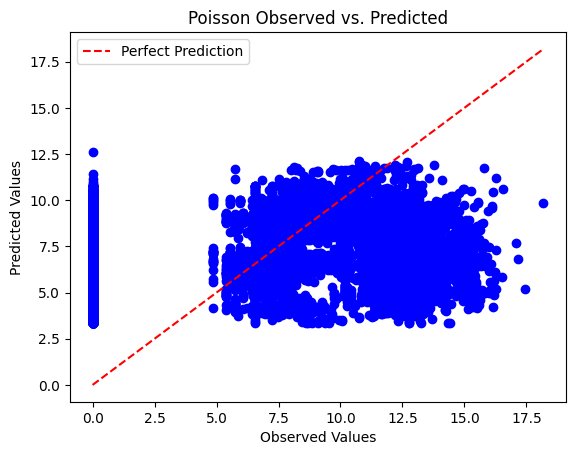

<Figure size 640x480 with 0 Axes>

In [71]:
plt.scatter(test_data['COVID_deaths_daily'], predictions_poisson, color='blue')
plt.plot([min(test_data['COVID_deaths_daily']), max(test_data['COVID_deaths_daily'])], [min(test_data['COVID_deaths_daily']), max(test_data['COVID_deaths_daily'])], linestyle='--', color='red', label='Perfect Prediction')
plt.title("Poisson Observed vs. Predicted")
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()
plt.savefig("fe_poisson_observed_vs_predicted.png")
#plots and saves observed vs. predictions graph

### Random Forest

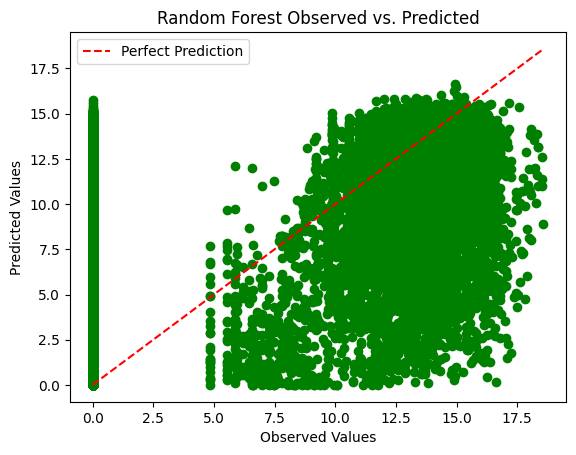

<Figure size 640x480 with 0 Axes>

In [72]:
plt.scatter(y_test, predictions_rf, color='green')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label='Perfect Prediction')
plt.title("Random Forest Observed vs. Predicted")
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()
plt.savefig("fe_poisson_observed_vs_predicted.png")
#plots and saves observed vs. predictions graph

### DNN

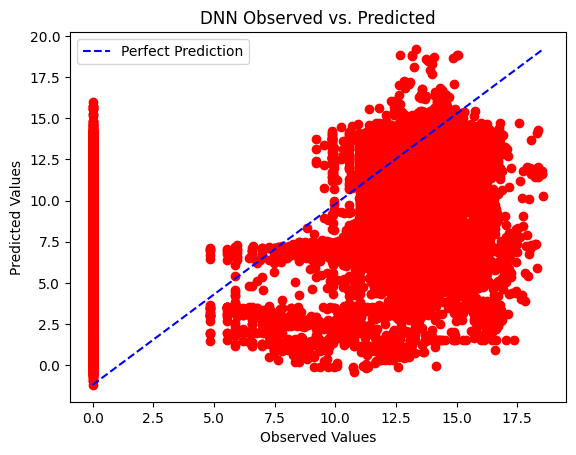

<Figure size 640x480 with 0 Axes>

In [73]:
plt.scatter(y_test, predictions_dnn,color='red')
plt.plot([min(y_test), max(y_test)], [min(predictions_dnn), max(predictions_dnn)], linestyle='--', color='blue', label='Perfect Prediction')
plt.title("DNN Observed vs. Predicted")
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()
plt.savefig("fe_dnn_observed_vs_predicted.png")
#plots and saves observed vs. predictions graph

In [74]:
log_step("Visually Displayed Analyzed Data")
#prints that step was completed

[2025-04-23 02:05:31] Visually Displayed Analyzed Data


## Generating Reports

In [75]:
log_step("Generating Reports")
#logs time of step

[2025-04-23 02:05:32] Generating Reports


### Poisson Regression

In [76]:
print(poisson.summary())
# prints model summary

                 Generalized Linear Model Regression Results                  
Dep. Variable:     COVID_deaths_daily   No. Observations:                53725
Model:                            GLM   Df Residuals:                    53720
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.5644e+05
Date:                Wed, 23 Apr 2025   Deviance:                   3.4414e+05
Time:                        02:05:32   Pearson chi2:                 2.31e+05
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3788
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.6064      0.00

In [77]:
mse_poisson = mean_squared_error(test_data['COVID_deaths_daily'], predictions_poisson)
print(f'Mean Squared Error: {mse_poisson}')

Mean Squared Error: 33.60495405550085


In [78]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
pseudo_r2_scores = []

for train_index, test_index in kf.split(data):
    train_data = data.iloc[train_index]
    test_data = data.iloc[test_index]

    model = smf.glm(formula='COVID_deaths_daily ~ COVID_doses_daily + time_index + sin_year + cos_year', data=train_data, family=sm.families.Poisson()).fit()
    predictions = model.predict(test_data)

    poisson_actual = test_data["COVID_deaths_daily"]
    mse_poisson = np.mean((poisson_actual - predictions_poisson)**2)
    
    null_model = smf.glm(formula="COVID_deaths_daily ~ 1", data=train_data, family=sm.families.Poisson()).fit()
    
    llf = model.llf
    llnull = null_model.llf 
    pseudo_r2 = 1 - (llf / llnull)
    pseudo_r2_scores.append(pseudo_r2)

print("Cross-validated MSE scores:", mse_poisson)
print(f"Pseudo R²: {pseudo_r2_scores}")
# performs cross validation and finds MSE and R-squared for poisson regression

Cross-validated MSE scores: 33.50836337221961
Pseudo R²: [0.10258297887409884, 0.10211526987769781, 0.10179679285875043, 0.10415597003880239, 0.1024017633566261]


### Random Forest

In [79]:
r2_rf = r2_score(y_test, predictions_rf)
print(f'R-squared: {r2_rf}')
#finds and prints R-squared

R-squared: 0.05391729756421548


In [80]:
mse_rf = mean_squared_error(y_test, predictions_rf)
print(f'Mean Squared Error: {mse_rf}')
# finds mse

Mean Squared Error: 32.32856985248587


In [81]:
cv_results_rf = cross_validate(rf, X_train, y_train, cv=5, scoring=['neg_mean_squared_error', 'r2'], return_train_score=True)
print("Cross Validate Log Test MSE:", -
cv_results_rf['test_neg_mean_squared_error'])
print("Cross Validate Log Test R²:", cv_results_rf['test_r2'])
# performs cross validation and finds MSE and R-squared for random forest

Cross Validate Log Test MSE: [38.0838458  39.95565307 52.80176013 44.66145879 46.86494099]
Cross Validate Log Test R²: [ 0.10952953  0.08905299 -0.17812218 -0.05663534  0.00753328]


### DNN

In [82]:
mse_dnn = mean_squared_error(y_test, predictions_dnn)
print(f'Mean Squared Error: {mse_dnn}')
r2_dnn = r2_score(y_test, predictions_dnn)
print(f'R-squared: {r2_dnn}')
#generates reports on original data

Mean Squared Error: 32.46089117504703
R-squared: 0.05004496683601567


In [84]:
with open("fe_model_report_log.txt", "w") as f:
    f.write("Feature Engineered Model Performance Report\n")
    f.write("========================\n")
    f.write(f"Poisson Mean Squared Error (MSE): " + str(mse_poisson) + "\n")
    f.write(f"Poisson R-squared (R²): " + str(poisson.summary()) + "\n")
    f.write(f"Cross-Validation (MSE): " + str(mse_poisson) + "\n")
    f.write(f"Average CV Score (R²): " + str(pseudo_r2_scores) + "\n")
    f.write(f"RF Mean Squared Error (MSE): " + str(mse_rf) + "\n")
    f.write(f"RF R-squared (R²): " + str(r2_rf) + "\n")
    f.write(f"Cross-Validation (MSE): " + str(cv_results_rf['test_r2']) + "\n")
    f.write(f"Average CV Score (R²): " + str(cv_results_rf['test_neg_mean_squared_error']) + "\n")
    f.write(f"DNN Mean Squared Error (MSE): " + str(mse_dnn) + "\n")
    f.write(f"DNN R-squared (R²): " + str(r2_dnn) + "\n")
# creates pdf of results

With all the reports generated through this product, it is recommended to stakeholders that these are examples of poor models, and no decisions should be made with them. It is further suggested that only more localized analysis should be performed with this type of data. Currently, there is too much variation, even after transformations and feature engineering to generate accurate predictions from.

In [83]:
log_step("Reports Generated")
#logs time of step

[2025-04-23 02:08:44] Reports Generated


## Interpretating the Data

The Poisson Regression with feature engineering had the following results: a pseudo R-squared of 0.3788, MSE of 33.60495405550085, cross-validated average MSE 33.50836337221961, and cross validated psuedo R-sqaured values of 0.10258297887409884, 0.10211526987769781, 0.10179679285875043, 0.10415597003880239, and 0.1024017633566261. The MSE is consistent with those of the original logarithmic transformed data models. The R-squared value did increase, but is still not high enough for any informed decisions. K-Folds cross validation further provided evidence of the model's inability to be trusted, as other psuedo R-squared values were 0.2 lower than the model generated. The prediction against observed values graph did show the most promise out of all previous generated graphs.

For the Random Forest model had the following results: R-squared of 0.05391729756421548, MSE of 32.32856985248587, Cross Validate MSE: [38.0838458  39.95565307 52.80176013 44.66145879 46.86494099], and Cross Validate R²: [ 0.10952953  0.08905299 -0.17812218 -0.05663534  0.00753328]. The R-squared value declined in performance and the MSE was consistent with other logarithmic transformed data MSEs. Cross validation scores did show variation among both MSE and R-squared values, furthering the unpredictability of the model. The graph of observed against predicted results appeared to be similarly structured to the model of the original logarithmic transformed data.

Finally, the DNN also did not show promising results. They were as follows: MSE of 32.46089117504703 and R-squared of 0.05004496683601567. The MSE was similar to that of all other logarithmic models, but the R-squared value decreased in performance. Its observed vs. predicted graph also was reminiscent of prior graphs for the logarithmic transformed data.

Overall, all modeling of the COVID-19 pandemic related data of vaccinations and deaths did not produce any viable models. All models did not show a strong enough performance and inconsitent results when cross validating. It is recommended with large health related data as this to analyze in smaller increments, focused on more localized areas. If using too large of a data set, there is risk of poor model performance, low likelihood of replicable results, and misinformed decision making.

## GUI Elements

The main GUI elements implemented were in the early graphs while exploring the data. As the main purpose of this product is to share results and knowledge on model performance for pandemic related data. These graphs included Box Plots for COVID-19 vaccinations and deaths, were a drop down box allowed for specific locations or the entirety of the world data was viewed. The box plot is important in outlier identification. This was also applied to histograms and line plots of the COVID-19 doses and related deaths. Histograms are important in
understanding the structure of the data, while the line plot could be utilized to indetify potential trends in the data. If an individual was interested in just local information, or how this compared to another area or the entire world data, it is
now visually available to them for visualizing outliers, data structure, and trends. Another visual aid provided was the COVID-19 vaccinations and deaths shown on a map of the world. As the daily rates did not appear to add much context,
cumulative counts were added and applied as a drop down option for the graph. This allows for people to see where potential areas of high or low activity for vaccinations administered or deaths due to the virus. All utlizied the update_layout() function from plotly (Plotly, n.d.). Otherwise, the product is fairly straight-forward, as analysis models and their results are printed. The additions enhance the user experience by providing a detailed and big picture viewpoints of the data. This could aid in analysis by identifying any areas that appearsignificant or as potential outliers to the user.

## Security

At this time, no security systems have been developed for the product. The data utilized is made publicly available and contains no personal identifiable information. As for the processing and modeling of the data, the purpose is for educational use, only. Testing of functions is performed to ensure all are appropriately working. If anyone were to make harmful changes to these, then they would only be preventing themselves from gaining insightful results.

If users upload data that contains personal information or develop their own product that is used for important decision making, then it is recommended that more measures are included for security. Additionally, any externally uploaded data should be fully preprocessed, as the current data was. The only exception is no implementations were performed for analyzing that the data type was appropriate for the data, as this must be examined and changed on an individual basis. All cleaning and preprocessing steps should be examined with introduction of new data, as well as analyzing the newly uploaded data for validity.

There is a risk that others could make changes to the models, and therefore, change the integrity of the model. It is recommended to all users to review the models for appropriate structure prior to implementation.

## Revisions

New additions to the product included more references, addressing security, creating a pop-up to allow url data uploads, adding tests to each function, and a help guide at the top of each file.

Updates to the files included a more in depth exploration of potential seasonality and trends in the data, fixing code to actually use the split of the train and test data, and updating codes so no warnings or error messages were received.

Failed attempts at revisions were introducing more feature engineering techniques for Poisson Regression, Random Forest, and DNN modeling. Introducing seasonality did not show increase performance in the models. As previous research has shown more success at predicting with more localized data, it is recommended to take this approach when analyzing pandemic related data.

From this information and the poor performance across all models, future goals are to attempt to rectify prior errors at improving model performance in new files. If these still return poor results, an exploration of learning data at a more local level will be the new objective to compare performance against.

For adherence to industry standards, it is imperative to have reproducibile and replicabile results (Gîrjău, Horton, & Pruim, 2023). Given this information, it is recommended to not make decisions from any of the current models. Any further implementations should focus on the logarithmic transformed data set. Additionally, the elimination of errors and warning messages follows best practices. It is also recommended to learn from the work of others. Prior work was used when devloping the models, as seen in the inserted referneces.

## References

Alroy-Preis, S., Angulo, F. Anis, E., Brooks, N., Haas, E. J., Jodar, :., Khan, F., Levy, Y., McLaughlin, J. M., Mircus, G., Pan, K., Singer, S. R., Smaja, M., Southern, J., & Swerdlow, D. L. (2021). Impact and effectiveness of mRNA BNT162b2 vaccine against SARS-CoV-2 infections and COVID-19 cases, hospitalisations, and deaths following a nationwide vaccination campaign in Israel: an observational study using national surveillance data. Lancet, 397(10287), 1819-1829. doi: 10.1016/S0140-6736(21)00947-8 

Appel, C., Beltekian, D., Dattani, S., Gavrilov, D., Giattino, C., Hasell, J.,
Macdonald, B., Mathieu, E., Ortiz-Ospina, E., Ritchie, H., Rodes-Guirao, L., &
Roser, M. (2025). COVID-19 pandemic [Data set]. Our World in Data.
https://ourworldindata.org/coronavirus

Barbeira, P. B., Bartolomeu, M. L., Castelli, J. M., Del Valle Juarez, M., Esperatti, M., Fuentes, N., Galligani, G., Giovacchini, C. M., Iummato, L. E., Laurora, M., Pennini, V., Pesce, M., Rearte, A. Rearte, R., Santoro, A., Tarragona, S., & Vizzotti, C. (2022). Effectiveness of rAd26-rAd5, ChAdOx1 nCoV-19, and BBIBP-CorV vaccines for risk of infection with SARS-CoV-2 and death due to COVID-19 in people older than 60 years in Argentina: a test-negative, case-control, and retrospective longitudinal study. Lancet, 399(10331), 1254-1264. doi: 10.1016/S0140-6736(22)00011-3 

Barron, J. A., Buenrostro-Mariscal, R., Crossa, J., Montesinos-Lopez, A.
Montesinos-Lopez, J. C., Montesinos-Lopez, O. A., & Salazar, E. (2021).
Application of a Poisson deep neural network model for the prediction of count
data in genome-based prediction. The Plant Genome, 14(3).
https://doi.org/10.1002/tpg2.20118

Brownlee, J. (2022). Your first deep learning project in Python with Keras step-by-step. *Machine Learning Mastery.* https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

Elliott, L., Loomis, D., & Richardson, D. B. (2005). Poisson regression analysis of
ungrouped data. Occupational and Environmental Medicine, 62, 325-329. DOI:
10.1136/oem.2004.017459

Fandohan, A. B., Kakaï, R. G., & Mushaglusa, C. Z. (2022). Random forest in count
data modelling: An analysis of the influence of data features and overdispersion
on regression performance. Journal of Probability and Statistics, 1.
https://doi.org/10.1155/2022/2833537

GeeksforGeeks. (2025). Ranom forest regression in Python. https://www.geeksforgeeks.org/random-forest-regression-in-python/ 

Gîrjău, M., Horton, N. J., & Prium, R. (2023). Fostering better coding practices for data scientists. HDSR. https://hdsr.mitpress.mit.edu/pub/8wsiqh1c/release/4

Katla, N. (2020). Poisson regression implementation- Python. *Medium.* https://medium.com/@kn12/poisson-regression-implementation-python-28d15e95dc15

Liu, J. (2024). Navigating the financial landscape: The power and limitations of
the ARIMA model. Highlights in Science, Engineering and Technology, 88, 747-752. https://drpress.org/ojs/index.php/HSET/article/view/19082/18645

National Cancer Institute. (2023). Cleaning data: The basics. Center for
Biomedical Informatics and Information Technology.
https://datascience.cancer.gov/training/learn-data-science/clean-data-basics

The Pennsylvania State University. (n.d.). 9: Poisson Regression.
https://online.stat.psu.edu/stat504/book/export/html/782#:~:text=Interpretations,tabletop%20of%20a%20certain%20area

Plotly. (n.d.). Creating and updating figures in Python.
https://plotly.com/python/creating-and-updating-figures/#updating-figures

Sarahjane3102. (2022). How to split the dataset With scikit-learn’s train_test_split() function *GeeksforGeeks.* https://www.geeksforgeeks.org/how-to-split-the-dataset-with-scikit-learns-train_test_split-function/